In [1]:
from maze import MazeEnv, ACTIONS
import numpy as np
import matplotlib.pylab as plt
from PIL import Image
from IPython import display
import numpy as np
from tqdm import tqdm

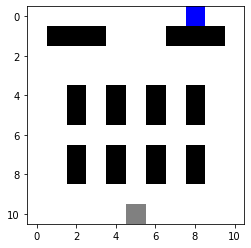

In [2]:
ACTION_LABELS = ['→', '←', '↓', '↑']
width, height = 11, 11
obstacle_positions = []
for x in range(4, 10):
    if x % 3 == 0:
        continue
    for y in range(2, 10, 2):
        obstacle_positions.append((x, y))

ws_positions = [(0, 2), (0, 8)]
ws_obstacles = []
for x, y in ws_positions:
    ws_obstacles += [(x+1, y-1), (x+1, y), (x+1, y+1)]

env = MazeEnv(width, height, (10, 5), ws_positions[1], obstacle_positions + ws_obstacles)
env.reset()
plt.imshow(env.render())
plt.show()

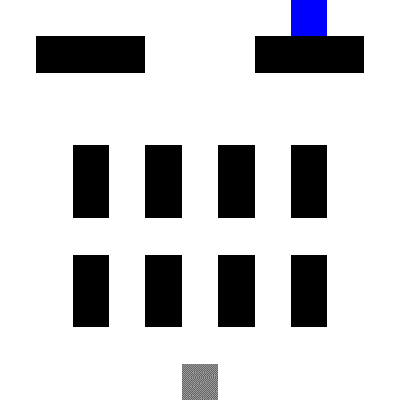

In [3]:
filename = 'imagedraw.gif'
images = []
env = MazeEnv(width, height, (10, 5), ws_positions[1], obstacle_positions + ws_obstacles)
state = env.reset()
done = False
reward_sum = 0.0

img = env.render()
im = Image.fromarray(img)
im = im.resize((400, 400), resample=0)
images.append(im)

while not done:
    action = np.random.choice(len(ACTIONS))
    state, reward, done, _ = env.step(action)
    # print(state, reward, done)
    reward_sum += reward
    img = env.render()
    im = Image.fromarray(img)
    im = im.resize((400, 400), resample=0)
    images.append(im)
    
images[0].save(filename,
               save_all=True, append_images=images[1:],
               optimize=False, duration=40, loop=0)


display.Image(filename)

In [4]:
from collections import defaultdict

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def generate_episode_from_Q(env, Q, epsilon):
    nA = env.action_space.n
    episode = []
    state = env.reset()
    done = False
    while not done:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA))                                     if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
    return episode

def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [5]:
env = MazeEnv(width, height, (10, 5), ws_positions[1], obstacle_positions + ws_obstacles)
num_episodes = 50000
alpha = 0.05

gamma= 0.9
eps_start=1.0
eps_decay=.99999
eps_min=0.01

# Main loop
nA = env.action_space.n

# Initialization
Q = defaultdict(lambda: np.zeros(nA))
epsilon = eps_start
# loop over episodes
for i_episode in tqdm(range(num_episodes)):
    epsilon = max(epsilon * eps_decay, eps_min)
    episode = generate_episode_from_Q(env, Q, epsilon)
    Q = update_Q(env, episode, Q, alpha, gamma)
policy = dict((k, np.argmax(v)) for k, v in Q.items())

100%|██████████| 50000/50000 [35:21<00:00, 23.57it/s] 


In [6]:
import pandas as pd
pd.DataFrame(Q).T.sort_index()

0          1          2          3
0  0  -14.777084 -19.988265 -12.629286 -16.815280
   1   -8.671988 -16.474880 -17.043611 -17.468979
   2   -6.493788 -11.194988 -14.190549 -13.962269
   3   -3.220456  -9.316229 -13.408075 -10.307598
   4   -1.344424  -7.386839  -2.802137 -11.275944
...          ...        ...        ...        ...
10 6  -13.524525 -13.361587 -18.664779 -14.677230
   7  -14.683368 -13.905573 -18.157517 -13.145445
   8  -14.737892 -14.717522 -17.804246 -13.982947
   9  -15.060934 -15.046101 -17.662715 -13.344061
   10 -18.679313 -14.324101 -19.258995 -14.475996

[98 rows x 4 columns]

In [7]:
env = MazeEnv(width, height, (10, 5), ws_positions[1], obstacle_positions + ws_obstacles)
episode = generate_episode_from_Q(env, Q, 0.01)
print(episode)

[((10, 5), 0, -1.0), ((10, 6), 1, -1.0), ((10, 5), 0, -1.0), ((10, 6), 1, -1.0), ((10, 5), 0, -1.0), ((10, 6), 1, -1.0), ((10, 5), 0, -1.0), ((10, 6), 1, -1.0), ((10, 5), 0, -1.0), ((10, 6), 1, -1.0), ((10, 5), 0, -1.0), ((10, 6), 1, -1.0), ((10, 5), 0, -1.0), ((10, 6), 1, -1.0), ((10, 5), 0, -1.0), ((10, 6), 1, -1.0), ((10, 5), 0, -1.0), ((10, 6), 1, -1.0), ((10, 5), 0, -1.0), ((10, 6), 1, -1.0), ((10, 5), 0, -1.0), ((10, 6), 1, -1.0), ((10, 5), 0, -1.0), ((10, 6), 1, -1.0), ((10, 5), 0, -1.0), ((10, 6), 1, -1.0), ((10, 5), 0, -1.0), ((10, 6), 1, -1.0), ((10, 5), 0, -1.0), ((10, 6), 1, -1.0), ((10, 5), 0, -1.0), ((10, 6), 1, -1.0), ((10, 5), 0, -1.0), ((10, 6), 1, -1.0), ((10, 5), 0, -1.0), ((10, 6), 1, -1.0), ((10, 5), 0, -1.0), ((10, 6), 1, -1.0), ((10, 5), 0, -1.0), ((10, 6), 1, -1.0), ((10, 5), 0, -1.0), ((10, 6), 1, -1.0), ((10, 5), 0, -1.0), ((10, 6), 1, -1.0), ((10, 5), 0, -1.0), ((10, 6), 1, -1.0), ((10, 5), 0, -1.0), ((10, 6), 1, -1.0), ((10, 5), 0, -1.0), ((10, 6), 1, -1.0),

In [8]:
env = MazeEnv(width, height, (10, 5), ws_positions[1], obstacle_positions + ws_obstacles)
episode = generate_episode_from_Q(env, Q, 0.00)
plt.imshow(env.render())
for state, action, reward in episode:
    x, y = state
    plt.text(y, x, str(ACTION_LABELS[action]),
    horizontalalignment='center',
    verticalalignment='center')
plt.show()

KeyboardInterrupt: 

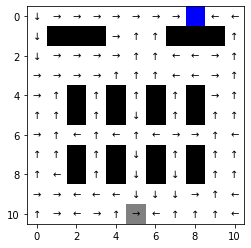

In [12]:
env = MazeEnv(width, height, (10, 5), ws_positions[1], obstacle_positions + ws_obstacles)
env.reset()
plt.imshow(env.render())
for x in range(width):
    for y in range(height):
        action = policy.get((x, y), None)
        if action is not None:
            plt.text(y, x, str(ACTION_LABELS[action]),
                horizontalalignment='center',
                verticalalignment='center')
plt.show()


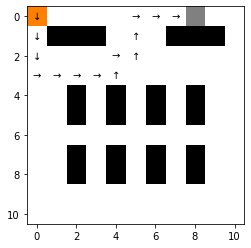

In [17]:
env = MazeEnv(width, height, (0, 0), ws_positions[1], obstacle_positions + ws_obstacles)
episode = generate_episode_from_Q(env, Q, 0.00)
plt.imshow(env.render())
for state, action, reward in episode:
    x, y = state
    plt.text(y, x, str(ACTION_LABELS[action]),
    horizontalalignment='center',
    verticalalignment='center')
plt.show()

In [10]:
print(episode)

[((0, 3), 0, -1.0), ((0, 4), 0, -1.0), ((0, 5), 2, -1.0), ((1, 5), 0, -1.0), ((1, 6), 2, -1.0), ((2, 6), 2, -1.0), ((3, 6), 2, -1.0), ((4, 6), 2, -1.0), ((5, 6), 2, -1.0), ((6, 6), 0, -1.0), ((6, 7), 2, 20.0)]


In [11]:
env = MazeEnv(width, height, (10, 5), ws_positions[1], obstacle_positions + ws_obstacles)
episode = generate_episode_from_Q(env, Q, 0.00)
print(episode, sum([r for _, _, r in episode]))


[((5, 2), 2, -1.0), ((6, 2), 0, -1.0), ((6, 3), 0, -1.0), ((6, 4), 0, -1.0), ((6, 5), 2, -1.0), ((7, 5), 0, -1.0), ((7, 6), 0, 20.0)] 14.0


In [24]:
import pickle
filename = "benchmark-{}x{}.pkl".format(width, height)
with open(filename, 'wb') as f:
    pickle.dump(dict(Q), f)

In [27]:
defaultdict(lambda: np.zeros(nA), dict(Q))

defaultdict(<function __main__.<lambda>()>,
            {(10,
              5): array([-13.53137015, -14.47742507, -17.46772636, -14.88573332]),
             (10,
              6): array([-13.52452547, -13.36158743, -18.66477943, -14.67723038]),
             (10,
              4): array([-15.42364569, -14.65054679, -19.26927458, -13.96557971]),
             (10,
              3): array([-13.90950935, -14.70498649, -18.69353327, -14.4478327 ]),
             (9,
              3): array([-15.16666205, -14.09723335, -14.38493317, -16.72164425]),
             (9,
              2): array([-14.88667174, -13.34378297, -14.85017408, -17.49950154]),
             (9,
              1): array([-14.06783061, -14.41160604, -15.56724587, -14.16872523]),
             (10,
              1): array([-14.43835824, -15.45593525, -18.78926904, -14.48899316]),
             (10,
              0): array([-15.33856152, -19.21121775, -18.29552832, -14.39736899]),
             (9,
              0): array([-13.8230